<a href="https://colab.research.google.com/github/ichiyan/BrainDecoding/blob/master/ldm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Nov 21 15:27:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [31]:
# import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional, List
from torch import optim
from tqdm import tqdm
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import logging
from PIL import Image


device = 'cuda'

logging.basicConfig(filename='', format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt = "%I:%M:%S")

# Basic Diffusion (in pixel space) 
- for reference only

In [ ]:
# TODO
#  - use image latent embeddings instead of image
#  - improve based on fast AI and LDM/SD
#  - add text cells for formulas used (see notes)

class Diffusion:
  def __int(self, schedule="linear", noise_steps=1000, beta_start=1e-4, beta_end=0.02, cosine_s=8e-3, img_size=64, device="cuda"):
    self.schedule = schedule
    self.noise_steps = noise_steps
    self.beta_start = beta_start
    self.beta_end = beta_end
    self.cosine_s = cosine_s
    self.img_size = img_size
    self.device = device

    self.beta = self.prepare_noise_schedule().to(device)
    self.alpha = 1. - self.beta
    self.alpha_bar = torch.cumprod(self.alpha, dim=0)

  # TODO: add dtype=torch.float64 ?
  def prepare_noise_schedule(self):
    if self.schedule == "linear":
      betas =  torch.linspace(self.beta_start, self.beta_end, self.noise_steps)
    
    elif self.schedule == "cosine":
      timesteps = (
          torch.arrange(self.noise_steps + 1) / self.noise_steps + self.cosine_s
      )

      alphas = timesteps / (1 + self.cosine_s) * np.pi / 2
      alphas = torch.cos(alphas).pow(2)
      alphas = alphas / alphas[0]
      betas = 1 - alphas[1:] / alphas[:-1]
      betas = np.clip(betas, a_min=0, a_max=0.999)
    
    return betas

  # adding noise in one single step instead of adding noise iteratively
  def noise_images(self, x, t):
    sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t])[:, None, None, None]
    sqrt_one_minus_alpha_bar = torch.sqrt(1. - self.alpha_bar[t])[:, None, None, None]
    epsilon = torch.randn_like(x)
    return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * epsilon, epsilon

  def sample_timesteps(self, n):
    return torch.randint(low=1, high=self.noise_steps, size=(n,))

  def sample(self, model, n):
    logging.info(f"Sampling {n} new images...")
    model.eval()
    with torch.no_grad():
      # create initial images by sampling from the normal distribution 
      x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
      # denoising loop 
      for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
        # creating timestep (tensor of length n with the current timestep)
        t = (torch.ones(n) * i).long().to(self.device)
        predicted_noise = model(x, t)
        alpha = self.alpha[t][:, None, None, None]
        alpha_bar = self.alpha_bar[t][:, None, None, None]
        beta = self.beta[t][:, None, None, None]

        if i > 1:
          noise = torch.randn_like(x)
        else:
          noise = torch.zeros_like(x)

        # remove portion of noise in image
        x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_bar))) * predicted_noise) + torch.sqrt(beta) * noise
      
      model.train()
      # clip values and then bring values back to 0-1
      x = (x.clamp(-1, 1) + 1) / 2
      # convert to valid pixel range and change data type for saving
      x = (x * 255).type(torch.uint8)

      return x





  


# Autoencoder (pretrained)

In [3]:
!pip install diffusers==0.2.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 112 kB 28.4 MB/s 
     |████████████████████████████████| 182 kB 59.8 MB/s 


In [4]:
from diffusers import AutoencoderKL
from huggingface_hub import notebook_login
from google.colab import output

output.enable_custom_widget_manager()
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [32]:
class Autoencoder():
    def __init__(self, device=device):
        self.vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
        self.vae = self.vae.to(device)

    def encode_img_latents(self, imgs):
        if not isinstance(imgs, list):
            imgs = [imgs]

        img_arr = np.stack([np.array(img) for img in imgs], axis=0)
        img_arr = img_arr / 255.0
        img_arr = torch.from_numpy(img_arr).float().permute(0, 3, 1, 2)
        img_arr = 2 * (img_arr - 0.5)

        img_arr

        latent_dists = self.vae.encode(img_arr.to(device))
        latent_samples = latent_dists.sample()
        latent_samples *= 0.18215

        return latent_samples

    def decode_img_latents(self, latents):
        latents = 1 / 0.18215 * latents

        with torch.no_grad():
            imgs = self.vae.decode(latents)

        imgs = (imgs / 2 + 0.5).clamp(0, 1)
        imgs = imgs.detach().cpu().permute(0, 2, 3, 1).numpy()
        imgs = (imgs * 255).round().astype('uint8')
        pil_images = [Image.fromarray(image) for image in imgs]
        return pil_images


# Brain Voxels Encoder

In [25]:
class BrainVoxelEmbedder():
  pass

# UNet Model

## Transformer (for cross attention conditioning)

TODO:
  - use flash attention?

In [26]:
class SpatialTransformer(nn.Module):
  def __init__(self, channels: int, n_heads: int, n_layers: int, d_cond: int):
    """
      :param channels: number of channels in the feature map
      :param n_heads: number of attention heads
      :param n_layers: number of transformer layers
      :param d_cond: size of conditional embedding
    """

    super().__init__()

    self.norm = nn.GroupNorm(num_groups=32, num_channels=channels, eps=1e-6, affine=True)
    self.proj_in = nn.Conv2d(channels, channels,  kernel_size=1, stride=1, padding=0)

    # Transformer layers
    self.transformer_blocks = nn.ModuleList(
        [BasicTransformerBlock(channels, n_heads, channels // n_heads, d_cond=d_cond) for _ in range(n_layers)]
    )

    self.proj_out = nn.Conv2d(channels, channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x: torch.Tensor, cond: torch.Tensor):
        """
          :param x: feature map of shape `[batch_size, channels, height, width]`
          :param cond: conditional embeddings of shape `[batch_size,  n_cond, d_cond]`
        """
        # Get shape `[batch_size, channels, height, width]`
        b, c, h, w = x.shape
        # For residual connection
        x_in = x
        # Normalize
        x = self.norm(x)
        # Initial 1x1 convolution
        x = self.proj_in(x)
        # Transpose and reshape from `[batch_size, channels, height, width]`
        # to `[batch_size, height * width, channels]`
        x = x.permute(0, 2, 3, 1).view(b, h * w, c)
        # Apply the transformer layers
        for block in self.transformer_blocks:
            x = block(x, cond)
        # Reshape and transpose from `[batch_size, height * width, channels]`
        # to `[batch_size, channels, height, width]`
        x = x.view(b, h, w, c).permute(0, 3, 1, 2)
        # Final 1x1 convolution
        x = self.proj_out(x)
        # Add residual
        return x + x_in

class BasicTransformerBlock(nn.Module):
  def __init__(self, d_model: int, n_heads: int, d_head: int, d_cond: int):
    """
      :param d_model: size of input embedding
      :param n_heads: number of attention heads
      :param d_head: size of attention head
      :param d_cond: size of conditional embeddings
    """
    super().__init__()

    # Self-attention layer and pre-norm layer
    self.attn1 = CrossAttention(d_model, d_model, n_heads, d_head)
    self.norm1 = nn.LayerNorm(d_model)
    # Cross attention layer and pre-norm layer
    self.attn2 = CrossAttention(d_model, d_cond, n_heads, d_head)
    self.norm2 = nn.LayerNorm(d_model)
    # Feed-forward network and pre-norm layer
    self.ff = FeedForward(d_model)
    self.norm3 = nn.LayerNorm(d_model)

    def forward(self, x: torch.Tensor, cond: torch.Tensor):
        """
        :param x: are the input embeddings of shape `[batch_size, height * width, d_model]`
        :param cond: is the conditional embeddings of shape `[batch_size,  n_cond, d_cond]`
        """
        # Self attention
        x = self.attn1(self.norm1(x)) + x
        # Cross-attention with conditioning
        x = self.attn2(self.norm2(x), cond=cond) + x
        # Feed-forward network
        x = self.ff(self.norm3(x)) + x
        #
        return x

class CrossAttention(nn.Module):
  def __init__(self, d_model: int, d_cond: int, n_heads: int, d_head: int, is_inplace: bool = True):
    """
      :param d_model: size of input embedding
      :param n_heads: number of attention heads
      :param d_head: size of attention head
      :param d_cond: size of conditional embeddings
      :param is_inplace: specifies whether to perform the attention softmax computation inplace to save memory
    """
    super().__init__()

    self.is_inplace = is_inplace
    self.n_heads = n_heads
    self.d_head = d_head

    # attention scaling factor
    self.scale = d_head ** -0.5

    # query, key, and value mappings
    d_attn = d_head * n_heads
    self.to_q = nn.Linear(d_model, d_attn, bias=False)
    self.to_k = nn.Linear(d_cond, d_attn, bias=False)
    self.to_v = nn.Linear(d_cond, d_attn, bias=False)

    self.to_out = nn.Sequential(nn.Linear(d_attn, d_model))

  def forward(self, x: torch.Tensor, cond: Optional[torch.tensor] = None):
    """
      :param x: input embeddings with shape [batch_size, height * width, d_model]
      :param cond: conditional embeddings with shape [batch_size, n_cond, d_cond]
    """
    # perform self attention if cond is None
    has_cond = cond is not None
    if not has_cond:
      cond = x

    q = self.to_q(x)
    k = self.to_k(cond)
    v = self.to_v(cond)

    self.normal_attention(q, k, v)

  def normal_attention(self, q: torch.Tensor, k: torch.Tensor, v: torch.Tensor):
    """
      :param q: query vectors before splitting heads; of shape [batch_size, seq, d_attn]
      :param k: query vectors before splitting heads; of shape [batch_size, seq, d_attn]
      :param v: query vectors before splitting heads; of shape [batch_size, seq, d_attn]
    """

    # split them to heads of shape [batch_size, seq_len, n_heads, d_head]
    q = q.view(*q.shape[:2], self.n_heads, -1)
    k = k.view(*k.shape[:2], self.n_heads, -1)
    v = v.view(*v.shape[:2], self.n_heads, -1)

    # calculate attention
    attn = torch.einsum('bihd,bjhd->bhij', q, k) * self.scale

    # compute softmax
    if self.is_inplace:
      half = attn.shape[0] // 2
      attn[half:] = attn[half:].softmax(dim=-1)
      attn[:half] = attn[:half].softmax(dim=-1)
    else:
      attn = attn.softmax(dim=-1)

    # compute attention output
    out = torch.einsum('bhij,bjhd->bihd', attn, v)

    # reshape to [batch_size, height * width, n_heads * d_head]
    out = out.reshape(*out.shape[:2], -1)

    # map to [batch_size, height * width, d_model] with linear layer
    return self.to_out(out)

class FeedForward(nn.Module):
    def __init__(self, d_model: int, d_mult: int = 4):
        """
          :param d_model: input embedding size
          :param d_mult: multiplicative factor for the hidden layer size
        """
        super().__init__()
        self.net = nn.Sequential(
            GeGLU(d_model, d_model * d_mult),
            nn.Dropout(0.),
            nn.Linear(d_model * d_mult, d_model)
        )

    def forward(self, x: torch.Tensor):
        return self.net(x)


class GeGLU(nn.Module):
    
    def __init__(self, d_in: int, d_out: int):
        super().__init__()
        self.proj = nn.Linear(d_in, d_out * 2)

    def forward(self, x: torch.Tensor):
        x, gate = self.proj(x).chunk(2, dim=-1)
        return x * F.gelu(gate)

## Other Modules

In [27]:
def normalization(channels):
    return GroupNorm32(32, channels)

class GroupNorm32(nn.GroupNorm):
    """
      Group normalization with float32 casting
    """
    def forward(self, x):
        return super().forward(x.float()).type(x.dtype)


class ResBlock(nn.Module):
    def __init__(self, channels: int, d_t_emb: int, *, out_channels=None):
        """
        :param channels: the number of input channels
        :param d_t_emb: the size of timestep embeddings
        :param out_channels: is the number of out channels. defaults to `channels.
        """
        super().__init__()
        # `out_channels` not specified
        if out_channels is None:
            out_channels = channels

        # First normalization and convolution
        self.in_layers = nn.Sequential(
            normalization(channels),
            nn.SiLU(),
            nn.Conv2d(channels, out_channels, 3, padding=1),
        )

        # Time step embeddings
        self.emb_layers = nn.Sequential(
            nn.SiLU(),
            nn.Linear(d_t_emb, out_channels),
        )
        # Final convolution layer
        self.out_layers = nn.Sequential(
            normalization(out_channels),
            nn.SiLU(),
            nn.Dropout(0.),
            nn.Conv2d(out_channels, out_channels, 3, padding=1)
        )

        # `channels` to `out_channels` mapping layer for residual connection
        if out_channels == channels:
            self.skip_connection = nn.Identity()
        else:
            self.skip_connection = nn.Conv2d(channels, out_channels, 1)

    def forward(self, x: torch.Tensor, t_emb: torch.Tensor):
        """
          :param x: is the input feature map with shape `[batch_size, channels, height, width]`
          :param t_emb: is the time step embeddings of shape `[batch_size, d_t_emb]`
        """
        # Initial convolution
        h = self.in_layers(x)
        # Time step embeddings
        t_emb = self.emb_layers(t_emb).type(h.dtype)
        # Add time step embeddings
        h = h + t_emb[:, :, None, None]
        # Final convolution
        h = self.out_layers(h)
        # Add skip connection
        return self.skip_connection(x) + h



class TimestepEmbedSequential(nn.Sequential):
    """
      This sequential module can compose of different modules such as ResBlock, nn.Conv, 
      and SpatialTransformer and calls them with the matching signatures
    """
    def forward(self, x, t_emb, cond=None):
        for layer in self:
            if isinstance(layer, ResBlock):
                x = layer(x, t_emb)
            elif isinstance(layer, SpatialTransformer):
                x = layer(x, cond)
            else:
                x = layer(x)
        return x

class UpSample(nn.Module):
    def __init__(self, channels: int):
        """
          :param channels: number of channels
        """
        super().__init__()

        self.conv = nn.Conv2d(channels, channels, 3, padding=1)

    def forward(self, x: torch.Tensor):
        """
          :param x: input feature map with shape [batch_size, channels, height, width]
        """

        # up-sample by a factor of 2
        x = F.interpolate(x, scale_factor=2, mode="nearest")

        return self.conv(x)

class DownSample(nn.Module):
    def __init__(self, channels: int):
        """
          :param channels: number of channels
        """
        super().__init__()

        # down-sample by a factor of 2
        self.op = nn.Conv2d(channels, channels, 3, stride=2, padding=1)

    def forward(self, x: torch.Tensor):
        """
          :param x: input feature map with shape [batch_size, channels, height, width]
        """
        return self.op(x)



## UNet 

In [28]:
class UNetModel(nn.Module):
    def __init__(
          self, *,
          in_channels: int,
          out_channels: int,
          channels: int,
          n_res_blocks: int,
          attention_levels: List[int],
          channel_multipliers: List[int],
          n_heads: int,
          tf_layers: int=1,
          d_cond: int = 768):
        
        """
            :param in_channels: is the number of channels in the input feature map
            :param out_channels: is the number of channels in the output feature map
            :param channels: is the base channel count for the model
            :param n_res_blocks: number of residual blocks at each level
            :param attention_levels: are the levels at which attention should be performed
            :param channel_multipliers: are the multiplicative factors for number of channels for each level
            :param n_heads: the number of attention heads in the transformers
            :param d_cond: is the size of the conditional embedding

        """
        """
            if using autoencoderKL with 256x256 image and encoded latent shape [1,4,32,32]
            TODO: also test results using 512x512 image and encoded latent shape [1,4,64,64]
              in_channels: 4
              out_channels: 4
              channels: 320
              n_res_blocks: 2
              attention_levels: [4,2,1] ==>  means add attention on spatial resolution 8,16,32
              channel_multipliers: [1,2,4,4]
              n_heads: 8
              d_cond:
        """

        super().__init__()
        self.channels = channels

        #  number of levels
        levels = len(channel_multipliers)
        
        # size time embeddings
        d_time_emb = channels * 4
        self.time_embed = nn.Sequential(
              nn.Linear(channels, d_time_emb),
              nn.SiLU(),
              nn.Linear(d_time_emb, d_time_emb),
              )
        
        # half of U-Net
        self.input_blocks = nn.ModuleList()

        # initial 3x3 convolution that maps the input to channels
        # different modules have different forward function signatures as defined in TimestepEmbedSequential 
        self.input_blocks.append(TimestepEmbedSequential(
            nn.Conv2d(in_channels, channels, 3, padding=1)
        ))

        # number of channels at each block in the inout half of U-Net 
        input_block_channels = [channels]

        # number of channels at each level 
        channels_list = [channels * m for m in channel_multipliers]

        
        for i in range(levels):
            for _ in range(n_res_blocks):
                #  residual block maps from previous number of channels to 
                #  the number of channels in the current level
                layers = [ResBlock(channels, d_time_emb, out_channels = channels_list[i])]
                channels = channels_list[i]

                if i in attention_levels:
                    layers.append(SpatialTransformer(channels, n_heads, tf_layers, d_cond))
                
                # add to input half of U-Net and keep track of number of channels of its output  
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                input_block_channels.append(channels)
                
                # down sample at all levels except last 
                if i!= levels - 1:
                    self.input_blocks.append(TimestepEmbedSequential(DownSample(channels)))
                    input_block_channels.append(channels)

        # middle of U-Net 
        self.middle_block = TimestepEmbedSequential(
            ResBlock(channels, d_time_emb),
            SpatialTransformer(channels, n_heads, tf_layers, d_cond),
            ResBlock(channels, d_time_emb),
        )
        
        # second half of U-Net  
        self.output_blocks = nn.ModuleList([])

        for i in reversed(range(levels)):
            for j in range(n_res_blocks + 1):
                # residual block maps from previous number of channels plus the skip connections
                # from the input half of U-Net to the number of channels in the current level  
                layers = [ResBlock(channels + input_block_channels.pop(), d_time_emb, out_channels=channels_list[i])]
                channels = channels_list[i]

                if i in attention_levels:
                    layers.append(SpatialTransformer(channels, n_heads, tf_layers, d_cond))

                # up sample at every level after last residual block except last one 
                if i != 0 and j == n_res_blocks:
                    layers.append(UpSample(channels)) 
                
                # add to ouput half of U-Net 
                self.output_blocks.append(TimestepEmbedSequential(*layers))
        
        # final norm and conv  
        self.out = nn.Sequential(
            normalization(channels),
            nn.SiLU(),
            nn.Conv2d(channels, out_channels, 3, padding=1)
        )

    def time_step_embedding(self, time_steps: torch.Tensor, max_period: int = 10000):
        """
          Create sinusoidal time step embeddings

          :param time_steps: time steps of shape `[batch_size]`
          :param max_period: controls the minimum frequency of the embeddings.
        """
    
        half = self.channels // 2
        frequencies = torch.exp(
            -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
        ).to(device=time_steps.device)
        args = time_steps[:, None].float() * frequencies[None]

        return torch.cat([torch.cos(args), torch.sin(args)], dim=-1)

    def forward(self, x: torch.Tensor, time_steps: torch.Tensor, cond: torch.Tensor):
          """
            :param x: input feature map of shape `[batch_size, channels, width, height]`
            :param time_steps: time steps of shape `[batch_size]`
            :param cond: conditioning of shape `[batch_size, n_cond, d_cond]`
          """
          # To store the input half outputs for skip connections
          x_input_block = []

          # Get time step embeddings
          t_emb = self.time_step_embedding(time_steps)
          t_emb = self.time_embed(t_emb)

          # Input half of the U-Net
          for module in self.input_blocks:
              x = module(x, t_emb, cond)
              x_input_block.append(x)
          # Middle of the U-Net
          x = self.middle_block(x, t_emb, cond)
          # Output half of the U-Net
          for module in self.output_blocks:
              x = torch.cat([x, x_input_block.pop()], dim=1)
              x = module(x, t_emb, cond)

          # Final normalization and 3x3 convolution
          return self.out(x)


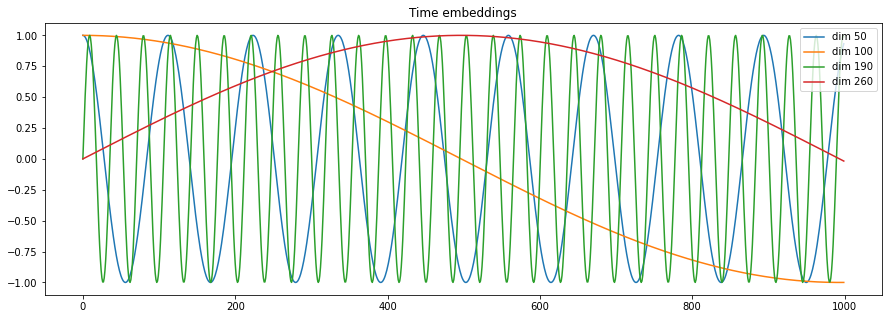

In [29]:
plt.figure(figsize=(15, 5))
m = UNetModel(in_channels=1, out_channels=1, channels=320, n_res_blocks=1, attention_levels=[], 
              channel_multipliers=[], n_heads=1, tf_layers=1, d_cond=1)
te = m.time_step_embedding(torch.arange(0, 1000))
plt.plot(np.arange(1000), te[:, [50, 100, 190, 260]].numpy())
plt.legend(["dim %d" % p for p in [50, 100, 190, 260]])
plt.title("Time embeddings")
plt.show()

# LDM
TODO:
  - add get model device method?
  - add cosine scheduler 
  - noising and sampling algos
  - loss computation
  - add autoencoder_decode in the sampling loop? 

In [30]:
class LatentDiffusion(nn.Module):
    def __init__(self, 
                 unet_model: UNetModel, 
                 autoencoder: Autoencoder, 
                 cond_embedder: BrainVoxelEmbedder,
                 latent_scaling_factor: float,
                 n_steps: int,
                 linear_start: float,
                 linear_end: float,
                 ):
          """
            :param unet_model: U-Net that predicts noise in latent space
            :param autoencoder: autoencoder in pixel space
            :param cond_embedder: conditional embeddings generator
            :param latent_scaling_factor: scaling factor for the latent space; the encodings of the autoencoder are scaled by this before feeding into the U-Net
            :param n_steps: number of diffusion steps T
            :param linear_start: start of the beta schedule
            :param linear_end: end of the beta schedule
          """

          super().__init__()

          self.model = unet_model
          self.first_stage_model = autoencoder
          self.latent_scaling_factor = latent_scaling_factor
          self.cond_stage_model = cond_embedder

          # number of steps T
          self.n_steps = n_steps

          # linear
          beta = torch.linspace(linear_start ** 0.5, linear_end ** 0.5, n_steps, dtype=torch.float64) ** 2
          self.beta = nn.Parameter(beta.to(torch.float32), requires_grad = False)

          alpha = 1. - beta
          alpha_bar = torch.cumprod(alpha, dim=0)
          self.alpha_bar = nn.Parameter(alpha_bar.to(torch.float32), requires_grad = False)

          # TODO: get model device?

    def get_brain_conditioning(self, voxels):
        pass

    def autoencoder_encode(self, image: torch.Tensor):
        # output of encoder is a sample from the distribution
        return self.latent_scaling_factor * self.first_stage_model.encode(image)

    def autoencoder_decode(self, z: torch.Tensor):
        # output of decoder is the image given the latent representation of the image
        return self.first_stage_model.decode(z / self.latent_scaling_factor)

    def forward(self, x: torch.Tensor, t: torch.Tensor, context: torch.Tensor):
        # predict noise given the latent representation, timestep, and the conditioning context
        return self.model(x, t, context)


# Exponential Moving Average (EMA)

# Training Loop